In [3]:
!pip install beautifulsoup4
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


First, we start by performing the same data gathering process that we used in the segmentation assignment to obtain a dataframe of postal codes/neighborhoods/coordinates in Toronto.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

coordinates_df = pd.read_csv('https://cocl.us/Geospatial_data')
coordinates_df

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


The following 3 cells are used to obtain an OAuth Token, which is used to obtain the ID's of people who liked a given venue.

In [3]:
CLIENT_ID = 'KVW5PYILN4Y1TKDPIYGKJQHWP1LBWGIBSWWNG2HA1VBWNY2V'
CLIENT_SECRET = 'OWJ32ZEVOIJEYK01H1TNFB3QQFGYOEIUCVQAKVBKZZIDYD11'

In [4]:
redirect_uri = 'https://www.google.com'
url1 = 'https://foursquare.com/oauth2/authenticate?client_id=%s&response_type=code&redirect_uri=%s' % (CLIENT_ID, redirect_uri)
print(url1)

https://foursquare.com/oauth2/authenticate?client_id=KVW5PYILN4Y1TKDPIYGKJQHWP1LBWGIBSWWNG2HA1VBWNY2V&response_type=code&redirect_uri=https://www.google.com


In [5]:
code = 'PZUUYTUTGXIVFGEWR4EMSXEXO3P0F50IV5YCD3B2OL0KLDB4#_=_'
url2 = 'https://foursquare.com/oauth2/access_token?client_id=%s&client_secret=%s&grant_type=authorization_code&redirect_uri=%s&code=%s' % (CLIENT_ID, CLIENT_SECRET,redirect_uri, code)
print(url2)

https://foursquare.com/oauth2/access_token?client_id=KVW5PYILN4Y1TKDPIYGKJQHWP1LBWGIBSWWNG2HA1VBWNY2V&client_secret=OWJ32ZEVOIJEYK01H1TNFB3QQFGYOEIUCVQAKVBKZZIDYD11&grant_type=authorization_code&redirect_uri=https://www.google.com&code=PZUUYTUTGXIVFGEWR4EMSXEXO3P0F50IV5YCD3B2OL0KLDB4#_=_


In [6]:
TOKEN = 'CFPISQMOGXEQM0LIOPCQLUN3X3Z0ASDQIKBHNZRJVJV5HYWE'

# parameters for the explore API query
LIMIT = 50
RADIUS = 1500
version = '20201222'

Next, we loop through a set of neighborhoods and retrieve the restaurants returned by an API call to Foursquare's "explore" endpoint. To reduce the number of total API calls made (which seem to be rate limited for at least part of the data I need), I am limiting the number of results returned. First, the number of restaurants returned by each call to the API is specified by the LIMIT parameter, and the neighborhoods are specified by the area_codes list. Currently, area_codes lists postal codes corresponding to the downtown Toronto area.

In [7]:
# get a list of {LIMIT} venues from the specified neighborhood.
def get_neighborhood_venues(lat, lng, init_code):

    # function to get primary category of venue
    def get_category(obj):
        if len(obj) == 0:
            return 'None'
        for category in obj:
            if category['primary'] == True:
                return category['shortName']
            else:
                print(obj)

    # parameters to pass to API call
    payload = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'categoryId': '4d4b7105d754a06374d81259',
        'll': '{},{}'.format(lat, lng), 
        'radius': RADIUS, 
        'v': version, 
        'limit': LIMIT,
    }
    print('Current Neighborhood: %s' % init_code)
    response = requests.get('https://api.foursquare.com/v2/venues/explore', params=payload).json()

    # if there was nothing in the response (i.e. an error code) return None for this postal code
    if 'groups' not in response['response']:
        print(init_code, response)
        return None
    
    # turn response json into dataframe, format headers
    df = pd.json_normalize(response['response']['groups'][0]['items'])
    df.columns = [header.replace('venue.', '').replace('location.', '') for header in df.columns]
    
    # if there is no categories column, skip and return None (probably too few results for particular postal code)
    if 'categories' not in df:
        print(init_code, response)
        return None
    
    # format postal code column: if none given in result, just use the initial search code.
    if 'postalCode' not in df.columns:
        df['postalCode'] = init_code
    df['postalCode'].fillna(init_code, inplace=True)
    df['postalCode'] = df['postalCode'].apply(lambda code: code.split(' ')[0])

    # apply the get_category method to 
    df['category'] = df['categories'].apply(lambda j: get_category(j))
    
    relevant_categories = ['id', 'name', 'postalCode', 'category', 'lat', 'lng']
    df = df[relevant_categories]
    return df

# subset of area codes to get restaurants for
area_codes = coordinates_df['Postal Code'].head(20)
# get rows of coordinates_df that have area codes in the area_codes list
downtown_rows = coordinates_df[coordinates_df['Postal Code'].isin(area_codes)]
# create a list of dataframes, each one containing the restaurant data returned for a postal code
venues_list = [get_neighborhood_venues(row.Latitude, row.Longitude, row._1) for row in downtown_rows.itertuples()]
# concatenate all of the dataframes together
venues_df = pd.concat(venues_list, axis=0)
print(venues_df.shape)
venues_df

Current Neighborhood: M1B
Current Neighborhood: M1C
Current Neighborhood: M1E
Current Neighborhood: M1G
Current Neighborhood: M1H
Current Neighborhood: M1J
Current Neighborhood: M1K
Current Neighborhood: M1L
Current Neighborhood: M1M
Current Neighborhood: M1N
Current Neighborhood: M1P
Current Neighborhood: M1R
Current Neighborhood: M1S
Current Neighborhood: M1T
Current Neighborhood: M1V
Current Neighborhood: M1W
Current Neighborhood: M1X
Current Neighborhood: M2H
Current Neighborhood: M2J
Current Neighborhood: M2K
(517, 6)


,id,name,postalCode,category,lat,lng
0,4b6718c2f964a5203f3a2be3,Harvey's,M1B,Restaurant,43.800020,-79.198307
1,4b914562f964a520d4ae33e3,Caribbean Wave,M1B,Caribbean,43.798558,-79.195777
2,579a91b3498e9bd833afa78a,Wendy's,M1B,Fast Food,43.802008,-79.198080
3,4bb6b9446edc76b0d771311c,Wendy’s,M1B,Fast Food,43.807448,-79.199056
4,4ba6f126f964a520ee7839e3,Pizza Pizza,M1B,Pizza,43.806613,-79.178445
...,...,...,...,...,...,...
0,5529a011498eddb919b0f2f5,Kori Sushi,M2K,Japanese,43.791613,-79.392267
1,4bd396d041b9ef3b799c00e6,Sun Star Chinese Cuisine 翠景小炒,M2K,Chinese,43.787914,-79.381234
2,4b32769df964a5205a0c25e3,Harvey's,M2K,Restaurant,43.792287,-79.393024
3,4bdc7dd8c79cc9287ecc86e9,Maxim's Cafe and Patisserie,M2K,Café,43.787863,-79.380751


Now that we have a dataframe listing all of the restaurant information we need, we clean the dataframe up a bit. We drop any fast food restaurants, since our analysis focuses on restaurants. Next, we drop any duplicate rows: some restaurants may have been returned in the searches for different neighborhoods if they were close to the border between those neighborhoods. As a result, we drop any rows which share ID's, keeping only one. Finally, we set the restaurant ID's to be the dataframe index, for easy indexing.

In [8]:
# drop fast food restaurants
venues_df = venues_df[venues_df['category'] != 'Fast Food']
print(venues_df.shape)
# drop duplicates: certain restaurants may have showed up in different neighborhoods' results
venues_df.drop_duplicates(subset='id', inplace=True)
# set the restaurant IDs as the index of the dataframe
venues_df.set_index('id', inplace=True)
venues_df.shape

(482, 6)


(460, 5)

In order to combine the different parameter matrices we construct, their values must be standardized (so that the values have mean 0 and standard deviation of 1). Since the parameter matrices are all symmetric, triangular matrices (i.e. only their upper/lower triangles are relevant), we flatten the upper triangle

In [9]:

# scale the matrix based on upper and lower triangles preserving symmetry (True)
# or scale each row of the matrix (excluding the diagonal values), ignoring symmetry (False)
TRIANGULAR=False
# use z-score standardization (True) or min-max scaling (False)
STANDARD=False

def triangular_standardize(df):
    nparray = df.to_numpy()
    # get the indices corresponding to the upper triangle of the array
    upper_indices = np.triu_indices(nparray.shape[0], k=1)
    # get the values of the upper triangle of the matrix
    upper_values = nparray[upper_indices]
    # set any infinite values to the max val of the matrix
    max_val = np.max(np.ma.masked_invalid(upper_values))
    upper_values[upper_values == np.inf] = max_val
    if STANDARD:
        upper_values = (upper_values - upper_values.mean())/upper_values.std()
    else:
        upper_values = (upper_values - upper_values.min())/(max_val - upper_values.min())
    # set the upper triangular indices of the inverse distance matrix to the scaled upper triangular values
    nparray[upper_indices] = upper_values
    # get lower indices
    lower_indices = np.tril_indices(nparray.shape[0], k=-1)
    # since the proximity matrix is symmetric, set the lower triangular indices to the scaled upper triangular values
    nparray[lower_indices] = nparray.T[lower_indices]
    df[:] = nparray
    return df

def dropinf_standardize(df):
    # replace all infinites with nan to use fillna
    df.replace(np.inf, np.nan, inplace=True)
    # get max of each row
    masked = np.ma.masked_invalid(df)
    maxs = masked.max(axis=1)
    # use fillna to fill each row's nan values with the row max
    max_map = {col: maxs[i] for i, col in enumerate(df.columns)}
    df = df.T.fillna(max_map).T
    # fill the diagonal with np.inf
    nparray = df.to_numpy()
    np.fill_diagonal(nparray, np.inf)
    # scale the array by row
    if STANDARD:
        means = masked.mean(axis=1)
        stds = masked.std(axis=1)
        nparray[:, :] = (nparray - means[:, None])/stds[:, None]
    else:
        mins = masked.min(axis=1)
        nparray[:, :] = (nparray - mins[:, None])/(maxs - mins)[:, None]
    # assign the scaled numpy array to the original dataframe and return it
    df[:] = nparray
    return df

def standardize(df):
    if TRIANGULAR:
        return triangular_standardize(df)
    return dropinf_standardize(df)

Let's create a matrix of distances that lists pairwise proximity between two restaurants. Let "proximity" be defined as the standardized inverse of the distance between two coordinates. As a result, the proximity will be a value that is higher when the distance between two coordinates is lower.

In [10]:
# Extract col-1 and 2 as latitudes and longitudes
lat = np.deg2rad(venues_df['lat'].to_numpy().flatten())                     
lng = np.deg2rad(venues_df['lng'].to_numpy().flatten())         

# Elementwise differences for lattitudes & longitudes
diff_lat = lat[:,None] - lat
diff_lng = lng[:,None] - lng

# Finally calculate haversine
d = np.sin(diff_lat/2)**2 + np.cos(lat[:,None])*np.cos(lat) * np.sin(diff_lng/2)**2
distance = np.arcsin(np.sqrt(d))
# make the inverse distance matrix: the log of the inverse of the distance matrix (taking log so that small values wouldn't be harshly penalized)
inv_distance = np.log(1/distance)

# standardize the inverse distance matrix
proximity_matrix = pd.DataFrame(inv_distance, columns = venues_df.index).set_index(venues_df.index)
proximity_matrix = standardize(proximity_matrix)
proximity_matrix.head(10)

id,4b6718c2f964a5203f3a2be3,4b914562f964a520d4ae33e3,4ba6f126f964a520ee7839e3,4b02dff3f964a520974a22e3,4ceaa2f0f8653704f906bec4,4c706524df6b8cfab244b84d,4b60878af964a520d9eb29e3,4bf01bf43a002d7f50ac85a4,4b89abadf964a520ae4a32e3,4b10352df964a520556b23e3,...,4e1a1e9188777e964780d302,4b8ab98ff964a520967c32e3,4be97325ee96c928c82fffbf,5cc33602c824ae002c675d4e,4cdac436c409b60c75c5d01a,5529a011498eddb919b0f2f5,4bd396d041b9ef3b799c00e6,4b32769df964a5205a0c25e3,4bdc7dd8c79cc9287ecc86e9,5404d153498ebbc7332f3e4e
id,,,,,,,,,,,,,,,,,,,,,
4b6718c2f964a5203f3a2be3,inf,0.612537,0.327178,0.966099,0.667034,0.661123,1.000000,0.656623,0.653743,0.482956,...,0.033749,0.053359,0.021781,0.049697,0.051575,0.000538,0.008933,0.0,0.009319,0.009033
4b914562f964a520d4ae33e3,0.751485,inf,0.413183,0.738482,0.655883,0.652158,0.763056,1.000000,0.999815,0.565781,...,0.041385,0.064905,0.026575,0.060631,0.062865,0.000660,0.010865,0.0,0.011333,0.010989
4ba6f126f964a520ee7839e3,0.974989,1.000000,inf,0.976325,0.961480,0.950719,0.974371,0.992804,0.989719,0.849046,...,0.083120,0.132131,0.054104,0.122774,0.127471,0.001315,0.022429,0.0,0.023410,0.022670
4b02dff3f964a520974a22e3,1.000000,0.623014,0.339121,inf,0.709529,0.698740,0.909511,0.664620,0.661261,0.496925,...,0.034869,0.055180,0.022518,0.051376,0.053323,0.000556,0.009239,0.0,0.009639,0.009343
4ceaa2f0f8653704f906bec4,0.774138,0.619939,0.373588,0.795585,inf,1.000000,0.757528,0.648101,0.645971,0.553487,...,0.038996,0.062049,0.025274,0.057655,0.059877,0.000622,0.010393,0.0,0.010845,0.010509
4c706524df6b8cfab244b84d,0.767163,0.616227,0.368917,0.783372,1.000000,inf,0.753184,0.644251,0.642971,0.566487,...,0.039209,0.062349,0.025397,0.057948,0.060177,0.000625,0.010438,0.0,0.010891,0.010554
4b60878af964a520d9eb29e3,1.000000,0.622014,0.326992,0.878685,0.652760,0.649118,inf,0.669724,0.667211,0.484698,...,0.033792,0.053388,0.021798,0.049737,0.051613,0.000539,0.008936,0.0,0.009323,0.009037
4bf01bf43a002d7f50ac85a4,0.628604,0.780596,0.319830,0.614729,0.534958,0.531925,0.641106,inf,1.000000,0.449393,...,0.032328,0.050797,0.020783,0.047419,0.049177,0.000515,0.008503,0.0,0.008869,0.008599
4b89abadf964a520ae4a32e3,0.625829,0.780437,0.318752,0.611603,0.533177,0.530843,0.638682,1.000000,inf,0.451705,...,0.032377,0.050857,0.020809,0.047481,0.049240,0.000516,0.008511,0.0,0.008879,0.008608


Text(0.5, 0, '$1/distance$')

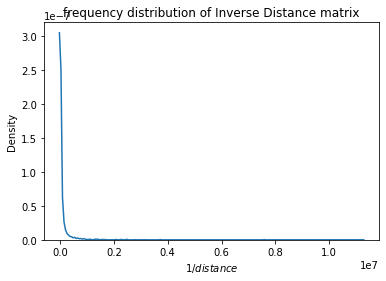

In [11]:
inv = 1/distance
loginv = np.log(1/distance)
ind = np.triu_indices(inv.shape[0], k=1)
inv_vals = inv[ind]
inv_vals = inv_vals[inv_vals != np.inf]
loginv_vals = loginv[ind]
loginv_vals = loginv_vals[loginv_vals != np.inf]
ax = sns.kdeplot(inv_vals)
plt.title('frequency distribution of Inverse Distance matrix')
plt.xlabel('$1/distance$')

Text(0.5, 0, '$log(1/distance)$')

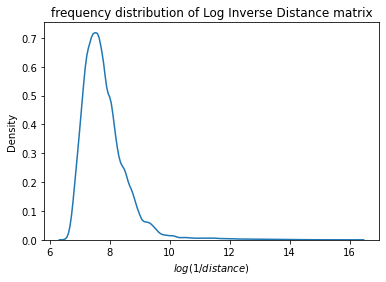

In [12]:
ax = sns.kdeplot(loginv_vals)
plt.title('frequency distribution of Log Inverse Distance matrix')
plt.xlabel('$log(1/distance)$')

In [13]:
import random

restaurant_index = random.randint(0, len(proximity_matrix.index))
restaurant_id = proximity_matrix.index.values[restaurant_index]
ten_closest = proximity_matrix.loc[restaurant_id, :].sort_values(ascending=False)[1:11]

closest_by_dist = np.argsort(distance[restaurant_index, :])[1:11]
closest_check = (proximity_matrix.index.values[closest_by_dist] == ten_closest.index.values).all()
print('Proximity matrix is consistent!') if closest_check else print('Discrepancy between actual distances and proximity matrix detected')

ten_closest.rename('score', inplace=True)
ten_closest_df = pd.merge(venues_df.loc[ten_closest.index.values, ['name', 'category']], ten_closest, left_index=True, right_index=True)
print(venues_df.loc[restaurant_id, ['name', 'category']])
print(ten_closest_df)


Proximity matrix is consistent!
name        Bluffer's Restaurant
category                 Seafood
Name: 4bb4e6eb0ef1c9b6ca94f412, dtype: object
                                                     name    category  \
id                                                                      
4d8ba6930c4e41bd10f9667f                      Pizza Pizza       Pizza   
4c730d9e8efc3704a3b7147d                           Subway  Sandwiches   
4bf193e399d02d7f1b4dc948             Little Caesars Pizza       Pizza   
4c9e27d87c096dcb1020d2d1                         Eggsmart   Breakfast   
4c894c9594f5a093f4f8d61e                        Bulk Barn      Snacks   
4c76d1c76981bfb7cc7c60e6  Ikki Sushi Japanese And Cuisine       Sushi   
4c2bcdf18ef52d7f16fc31ba                Big Boy's Burgers  Restaurant   
4c952867533aa093f374c645                      Pizza Pizza       Pizza   
4eb060409adff29daf3c7a58                           Subway  Sandwiches   
4bb8def77421a5933335c240                       Pizza 

In [14]:
import folium

map = folium.Map(location=venues_df.loc[restaurant_id, ['lat', 'lng']], zoom_start=15)
this_rest_marker = folium.CircleMarker(
    venues_df.loc[restaurant_id, ['lat', 'lng']],
    popup=venues_df.loc[restaurant_id, 'name'],
    fill=True
)
ten_closest_grp = folium.FeatureGroup()
for i, id in enumerate(ten_closest.index):
    ten_closest_grp.add_child(
        folium.CircleMarker(
            location=venues_df.loc[id, ['lat', 'lng']],
            popup='{}. {}: {}'.format(i+1, venues_df.loc[id, 'name'],
                                      ten_closest_df.loc[id, 'score']),
            color='#ff0000',
            fill=True
        )
    )
map.add_child(this_rest_marker)
map.add_child(ten_closest_grp)
map

In [15]:
categories = venues_df['category'].to_numpy().flatten()
category_matrix = (categories[:, None] == categories).astype(float)
category_df = pd.DataFrame(category_matrix, columns=venues_df.index).set_index(venues_df.index)
category_df = standardize(category_df)
category_df

id,4b6718c2f964a5203f3a2be3,4b914562f964a520d4ae33e3,4ba6f126f964a520ee7839e3,4b02dff3f964a520974a22e3,4ceaa2f0f8653704f906bec4,4c706524df6b8cfab244b84d,4b60878af964a520d9eb29e3,4bf01bf43a002d7f50ac85a4,4b89abadf964a520ae4a32e3,4b10352df964a520556b23e3,...,4e1a1e9188777e964780d302,4b8ab98ff964a520967c32e3,4be97325ee96c928c82fffbf,5cc33602c824ae002c675d4e,4cdac436c409b60c75c5d01a,5529a011498eddb919b0f2f5,4bd396d041b9ef3b799c00e6,4b32769df964a5205a0c25e3,4bdc7dd8c79cc9287ecc86e9,5404d153498ebbc7332f3e4e
id,,,,,,,,,,,,,,,,,,,,,
4b6718c2f964a5203f3a2be3,inf,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4b914562f964a520d4ae33e3,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4ba6f126f964a520ee7839e3,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4b02dff3f964a520974a22e3,1.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4ceaa2f0f8653704f906bec4,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529a011498eddb919b0f2f5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,inf,0.0,0.0,0.0,1.0
4bd396d041b9ef3b799c00e6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0
4b32769df964a5205a0c25e3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0


Next, create the cross-reference matrix and the venue likes vector. The cross-reference matrix contains, for each element $M_{ij}$, the number of unique foursquare users who indicated that they liked both restaurant $i$ and restaurant $j$. As a result, this matrix is symmetric. The venue likes vector contains the count of likes for each restaurant.

Since the specific api call to get full user information (i.e. including the user ID) for each user that liked a given venue seems limited to 500/day, I include an OVERWRITE parameter: when set to `True`, it calls the API for each restaurant in the venues dataframe, populates the cross-reference matrix and the venue likes vector, and stores them both in CSV files. When set to `False`, the cross-reference matrix and venue likes vector are both loaded from the CSV file in the directory, bypassing the API.

In [16]:
import os

OVERWRITE = False

if 'cross_reference.csv' in os.listdir() and not OVERWRITE:
    cross_reference_df = pd.read_csv('cross_reference.csv', index_col=0)
    venue_likes = pd.read_csv('venue_likes.csv', index_col=0, squeeze=True)
else:
    cross_reference_df = pd.DataFrame(np.zeros(category_matrix.shape), columns=venues_df.index, dtype=int).set_index(venues_df.index)
    # dictionary mapping user id's to the venues they've visited
    user_venues_dict = {}
    venue_likes = np.zeros(venues_df.index.shape[0])
    payload = {
        'oauth_token': TOKEN,
        'v': version, 
    }
    # go through each venue's likes
    for i, venue_id in enumerate(venues_df.index):
        r = requests.get('https://api.foursquare.com/v2/venues/%s/likes' % venue_id, params=payload).json()
        print(i, venue_id)
        target_info = r['response']['likes']
        # store count of likes for this venue in venue_likes
        venue_likes[i] = target_info['count']
        # if this venue has information on users that have liked this venue
        if 'items' in target_info:
            # loop through each user
            for item in target_info['items']:
                user_id = item['id']
                ''' if the user exists in the user_venues dict already, that means that they have already liked at  least one restaurant that has been previously examined. For each of the the previously examined restaurants, we increment their indices in the row of the current restaurant since this user has liked both restaurants. We also do this for the opposite coordinate, since the matrix is symmetrical by definition. '''
                if user_id in user_venues_dict:
                    cross_reference_df.loc[user_venues_dict[user_id], venue_id] += 1
                    cross_reference_df.loc[venue_id, user_venues_dict[user_id]] += 1
                # append the current venue to the list of venues the user has visited; if no list exists for the user, make one and append it to that.
                user_venues_dict.setdefault(user_id, []).append(venue_id)

    # export both cross_reference_df and venue_likes to their own csv files
    cross_reference_df.to_csv('cross_reference.csv')
    venue_likes = pd.Series(venue_likes, index=venues_df.index)
    venue_likes.to_csv('venue_likes.csv')
cross_reference_df

,4b6718c2f964a5203f3a2be3,4b914562f964a520d4ae33e3,4ba6f126f964a520ee7839e3,4b02dff3f964a520974a22e3,4ceaa2f0f8653704f906bec4,4c706524df6b8cfab244b84d,4b60878af964a520d9eb29e3,4bf01bf43a002d7f50ac85a4,4b89abadf964a520ae4a32e3,4b10352df964a520556b23e3,...,4e1a1e9188777e964780d302,4b8ab98ff964a520967c32e3,4be97325ee96c928c82fffbf,5cc33602c824ae002c675d4e,4cdac436c409b60c75c5d01a,5529a011498eddb919b0f2f5,4bd396d041b9ef3b799c00e6,4b32769df964a5205a0c25e3,4bdc7dd8c79cc9287ecc86e9,5404d153498ebbc7332f3e4e
id,,,,,,,,,,,,,,,,,,,,,
4b6718c2f964a5203f3a2be3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4b914562f964a520d4ae33e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4ba6f126f964a520ee7839e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4b02dff3f964a520974a22e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4ceaa2f0f8653704f906bec4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529a011498eddb919b0f2f5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4bd396d041b9ef3b799c00e6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4b32769df964a5205a0c25e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Scale both the venue likes vector and the cross reference matrix according to the algorithm(s) chosen during data processing.

In [17]:
if STANDARD:
    venue_likes = (venue_likes - venue_likes.mean())/venue_likes.std()
else:
    venue_likes = (venue_likes - venue_likes.min())/(venue_likes.max() - venue_likes.min())

cross_reference_df = standardize(cross_reference_df.astype(float))

In [18]:
cross_reference_df.replace(np.inf, 0, inplace=True)
cross_reference_df.max().sort_values().tail(20)

4cddfe25db125481ff0b2ece    1.0
4d83951502eb5481e3c71cf5    1.0
4c69ed7735d3be9a1ec02006    1.0
4dc1ab7b1f6e7441cf537631    1.0
583f175dfbe8ff549afaa9fd    1.0
4c87cbf733453704ead91572    1.0
4c5994d8ec2520a1375a4f12    1.0
4e01416852b1ac66aac9ccba    1.0
4d24ed44d713b1f794e1da53    1.0
4eb70cecd3e3644ca6ea9b31    1.0
4b5cc7c9f964a520a84329e3    1.0
52d5ac8f11d2476f50fe5fbb    1.0
4d728acd27ddb60cb58fcf1b    1.0
4cf6580c6658548187c8c898    1.0
4b880980f964a520d3da31e3    1.0
4b25c9fcf964a5203b7624e3    1.0
4b25ca77f964a520417624e3    1.0
4f628870e4b04b2441e12431    1.0
4d658b7c89238cfaa5129b36    1.0
5404d153498ebbc7332f3e4e    1.0
dtype: float64

In order to verify that the scaling method we chose for the factor matrices (proximity, category, cross-reference, and venue likes) produces a desirable distribution of data, we plot the frequency distribution of values for the restaurant_id row in each matrix (and for venue_likes, the entire vector). A desirable set of distributions would have all of the values in the same range, preferably around 0-1, so that no one factor has too much influence on the recommendation.

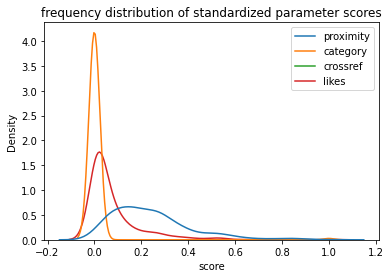

In [19]:
def plot_score_dists(restaurant_id, matrices, names):
    restaurant_scores = []
    for matrix in matrices:
        if len(matrix.shape) == 1:
            restaurant_scores.append(matrix[matrix.index != restaurant_id])
        if len(matrix.shape) == 2:
            restaurant_scores.append(matrix.loc[restaurant_id, matrix.columns != restaurant_id])
    score_dist_df = pd.concat(restaurant_scores, axis=1)
    score_dist_df.columns = names
    ax = sns.kdeplot(data=score_dist_df)
    plt.xlabel('score')
    plt.title('frequency distribution of standardized parameter scores')
    
plot_score_dists(restaurant_id, [proximity_matrix, category_df, cross_reference_df, venue_likes],
                names=['proximity', 'category', 'crossref', 'likes'])

Add together all of the score matrices in order to produce the recommendation matrix. Since the venue_likes vector is broadcasted over the columns (i.e. the same value is added to each element in a column), indexing into the recommendation matrix is done row by column.

In [20]:

recommendation_matrix = proximity_matrix + category_df + cross_reference_df + venue_likes
print(recommendation_matrix.shape)
recommendation_matrix

(460, 460)


id,4b6718c2f964a5203f3a2be3,4b914562f964a520d4ae33e3,4ba6f126f964a520ee7839e3,4b02dff3f964a520974a22e3,4ceaa2f0f8653704f906bec4,4c706524df6b8cfab244b84d,4b60878af964a520d9eb29e3,4bf01bf43a002d7f50ac85a4,4b89abadf964a520ae4a32e3,4b10352df964a520556b23e3,...,4e1a1e9188777e964780d302,4b8ab98ff964a520967c32e3,4be97325ee96c928c82fffbf,5cc33602c824ae002c675d4e,4cdac436c409b60c75c5d01a,5529a011498eddb919b0f2f5,4bd396d041b9ef3b799c00e6,4b32769df964a5205a0c25e3,4bdc7dd8c79cc9287ecc86e9,5404d153498ebbc7332f3e4e
id,,,,,,,,,,,,,,,,,,,,,
4b6718c2f964a5203f3a2be3,inf,0.698743,0.353040,2.086788,0.710138,0.669744,1.017241,0.665243,0.679606,0.595025,...,0.033749,0.053359,0.039022,0.066938,0.051575,0.078124,0.069277,1.198276,0.104147,0.026275
4b914562f964a520d4ae33e3,0.846313,inf,0.439046,0.859172,0.698986,0.660778,0.780298,1.008621,1.025677,0.677850,...,0.041385,0.064905,0.043817,0.077872,0.062865,0.078246,0.071210,0.198276,0.106161,0.028230
4ba6f126f964a520ee7839e3,1.069816,1.086207,inf,1.097015,1.004583,0.959340,0.991612,1.001425,1.015581,1.961115,...,0.083120,0.132131,1.071345,0.140015,0.127471,0.078901,0.082774,0.198276,0.118238,0.039911
4b02dff3f964a520974a22e3,2.094828,0.709221,0.364983,inf,0.752633,0.707361,0.926752,0.673240,0.687123,0.608994,...,0.034869,0.055180,0.039760,0.068617,0.053323,0.078142,0.069584,1.198276,0.104467,0.026584
4ceaa2f0f8653704f906bec4,0.868966,0.706146,0.399450,0.916274,inf,1.008621,0.774769,0.656722,0.671833,0.665556,...,0.038996,0.062049,0.042515,0.074897,0.059877,0.078208,0.070738,0.198276,0.105672,0.027750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529a011498eddb919b0f2f5,0.122150,0.111164,0.033996,0.148053,0.071748,0.037762,0.044505,0.034233,0.051562,0.145553,...,0.262896,0.234677,0.383923,1.249184,0.230631,inf,0.617564,1.198276,0.644816,1.570992
4bd396d041b9ef3b799c00e6,0.116845,0.106330,0.031940,0.142733,0.066164,1.032099,0.039217,0.029271,0.046589,0.139292,...,0.232143,0.205636,0.363059,0.220427,0.201930,0.504278,inf,0.612180,1.000846,1.017241
4b32769df964a5205a0c25e3,1.122125,0.111139,0.034083,1.148030,0.071727,0.037736,0.044480,0.034207,0.051536,0.145478,...,0.259507,0.232223,0.377864,0.246616,0.228131,1.077586,0.601473,inf,0.629394,0.555114


In [21]:
print(venues_df.loc[restaurant_id, ['name', 'category']])
scores = recommendation_matrix.loc[restaurant_id, :].sort_values(ascending=False)[1:11]
scores.rename('score', inplace=True)
recs = venues_df.loc[scores.index.values, ['name', 'category']]
recs_merged = pd.merge(recs, scores, left_index=True, right_index=True)
recs_merged

name        Bluffer's Restaurant
category                 Seafood
Name: 4bb4e6eb0ef1c9b6ca94f412, dtype: object


,name,category,score
id,,,
4b16bf72f964a520e4bc23e3,Red Lobster,Seafood,1.697973
4e4ea736aeb70f128495108f,Diana's Oyster Bar & Grill,Seafood,1.682460
58581034d25ded6c2984dc67,The Captain's Boil,Seafood,1.254436
4b1b43d1f964a52057fa23e3,Jack Astor's Bar & Grill,Restaurant,1.078130
4b29222af964a520679924e3,Congee Queen 皇后名粥,Cantonese,1.014123
4d8ba6930c4e41bd10f9667f,Pizza Pizza,Pizza,1.000000
4c9e27d87c096dcb1020d2d1,Eggsmart,Breakfast,0.901320
4c730d9e8efc3704a3b7147d,Subway,Sandwiches,0.891413
4bf193e399d02d7f1b4dc948,Little Caesars Pizza,Pizza,0.890322


<AxesSubplot:ylabel='Density'>

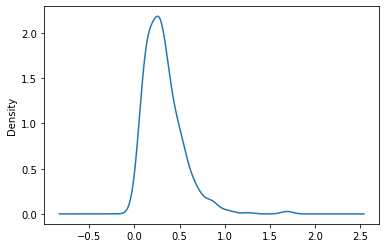

In [22]:
rmnoinf = recommendation_matrix.loc[restaurant_id, recommendation_matrix.columns != restaurant_id]
rmnoinf.plot(kind='kde')

In [23]:
param_list = [k.loc[restaurant_id, scores.index] for k in [proximity_matrix, category_df, cross_reference_df]] + [venue_likes[scores.index]]
attributes = pd.concat(param_list, axis=1)
attributes.columns = ['proximity', 'category', 'crossref', 'likes']
attributes

,proximity,category,crossref,likes
id,,,,
4b16bf72f964a520e4bc23e3,0.163490,1.0,0.0,0.534483
4e4ea736aeb70f128495108f,0.329011,1.0,0.0,0.353448
58581034d25ded6c2984dc67,0.194091,1.0,0.0,0.060345
4b1b43d1f964a52057fa23e3,0.250544,0.0,0.0,0.827586
4b29222af964a520679924e3,0.014123,0.0,0.0,1.000000
4d8ba6930c4e41bd10f9667f,1.000000,0.0,0.0,0.000000
4c9e27d87c096dcb1020d2d1,0.849596,0.0,0.0,0.051724
4c730d9e8efc3704a3b7147d,0.882793,0.0,0.0,0.008621
4bf193e399d02d7f1b4dc948,0.873081,0.0,0.0,0.017241


[]

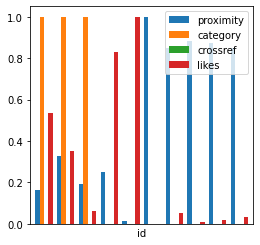

In [29]:
# attributes = attributes.loc[:, (attributes != 0).any(axis=0)]
ax = attributes.plot(kind='bar', width=0.8, align='center', figsize=(4,4))
ax.get_xaxis().set_ticks([])